In [49]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

## Allocation - rebalancement annuel

On fixe comme fin "2021-01-12" pour continuer de trader sur la dernière année (si on a pas assez d'instants, le rebalancement ne se fait plus) (2345 instants jusqu'à fin avril 2020)

In [50]:
def get_data(tickers, start_date, end_date):
    """Récupère les données historiques des actifs"""
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close']
    return data

In [51]:
spot = get_data(['AGG', 'DBC', 'VTI', '^VIX'], "2011-01-01", "2021-01-12").to_numpy()
years=10

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [52]:
def simulate_portfolio(spot, years, allocation, C=0.0001, rebalancing_freq='yearly'):
   
    N = len(spot)
    d = len(allocation)
    t = np.linspace(start=0, stop=years, num=N)
    
    # Définir les indices de rebalancement selon la fréquence
    if rebalancing_freq == 'yearly':
        index_rebalancing = np.arange(0, N, 21*12)
    elif rebalancing_freq == 'monthly':
        index_rebalancing = np.arange(0, N, 21)
    else:  # daily
        index_rebalancing = np.arange(0, N, 1)
    
    # Initialisation
    portfolio_value = np.ones(shape=N)
    weights_actual = np.zeros(shape=(N, d))
    weights_target = np.tile(allocation, (len(index_rebalancing), 1))
    rebalancing_cost = np.zeros(shape=len(index_rebalancing))
    
    # Simulations
    for s, (start, stop) in enumerate(zip(index_rebalancing[:-1], index_rebalancing[1:])):
        period = slice(start, stop+1)
        rebalancing_cost[s] = portfolio_value[start] * np.abs(weights_target[s] - weights_actual[start]).sum() * C
        weights_actual[period] = (spot[period] / spot[start]) * weights_target[s]
        weights_actual[period] /= weights_actual[period].sum(axis=1, keepdims=True)
        portfolio_returns = (spot[period] / spot[start] - 1) @ weights_target[s]
        portfolio_value[period] = (portfolio_value[start] - rebalancing_cost[s]) * (1 + portfolio_returns)
    
    
    return t, portfolio_value, weights_actual, weights_target, index_rebalancing, rebalancing_cost

In [53]:
def plot_portfolio_analysis(
    t,
    spot,
    portfolio_value,
    weights_actual,
    weights_target,
    index_rebalancing,
    rebalancing_cost,
    asset_names: list = ['AGG', 'DBC', 'VTI', '^VIX'],
    figsize: tuple = (12, 8)
) -> tuple:

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=figsize)
    
    # 1) Valeurs sous-jacents
    ax = axes[0, 0]
    ax.set_title("Valeurs sous-jacents")
    ax.plot(t, spot)
    ax.set_yscale("log")
    ax.legend(asset_names)
    ax.grid(True, alpha=0.3)
    
    # 2) Valeur portefeuille
    ax = axes[0, 1]
    ax.set_title("Valeur portefeuille")
    ax.plot(t, portfolio_value, color='darkblue')
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    
    # Calcul et affichage des métriques de performance
    returns = pd.Series(portfolio_value).pct_change().dropna()
    volatility = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    
    # Ajout des métriques sur le graphique
    ax.text(0.02, 0.98, 
            f'Rendement: {returns.mean() * 252*100:.1f}%\n'
            f'Volatilité: {volatility*100:.1f}%\n'
            f'Ratio de Sharpe: {sharpe:.2f}',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top',
            fontsize=8)

    # 3) Poids portefeuille
    ax = axes[1, 0]
    ax.set_title("Poids portefeuille")
    ax.stackplot(t, *weights_actual.T, labels=asset_names)
    
    # Normalisation et tracé des poids théoriques
    weights_theory = weights_target.copy()
    weights_theory /= weights_theory.sum(axis=1, keepdims=True)
    ax.plot(t[index_rebalancing], 
            weights_theory.cumsum(axis=1),
            color="lightgrey",
            linestyle='--',
            alpha=0.7)
    ax.legend(asset_names)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # 4) Coûts de transaction
    ax = axes[1, 1]
    ax.set_title("Coûts de transaction cumulés")
    ax.step(t[index_rebalancing],
            rebalancing_cost.cumsum(),
            where="post",
            color='darkred')
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)
    
    # Ajout du coût total sur le graphique
    total_cost = rebalancing_cost.sum()
    ax.text(0.02, 0.98,
            f'Coût Total: {total_cost:.4f}',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top',
            fontsize=8)
    
    # Ajustement de la mise en page
    fig.tight_layout()
    
    return fig, axes


In [54]:
allocation1 = [0.25, 0.25, 0.25, 0.25]
allocation2 = [0.5, 0.1, 0.2, 0.2]
allocation3 = [0.1, 0.5, 0.2, 0.2]
allocation4 = [0.4, 0.4, 0.1, 0.1]


Allocation 1 = [0.25, 0.25, 0.25, 0.25], C=1bps, Pas de volatility scaling (rebalancement annuel)

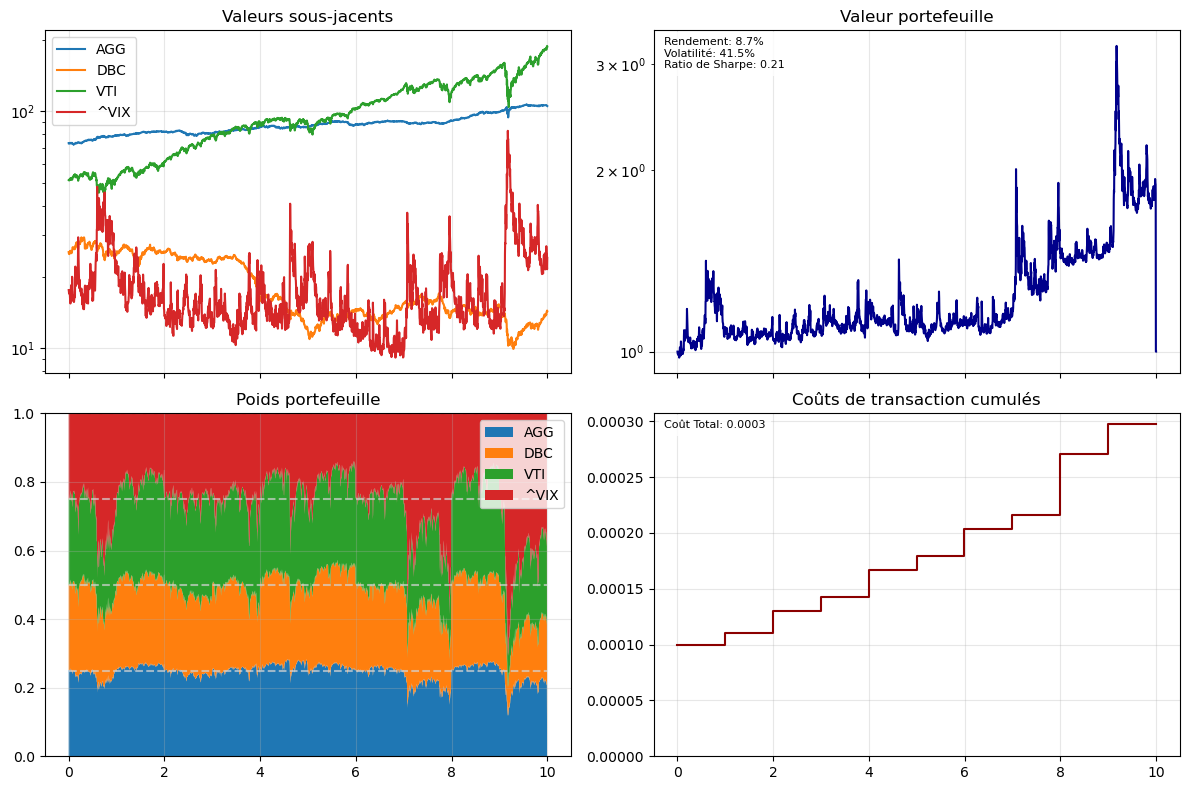

In [55]:
t, portfolio_value, weights_actual, weights_target, index_rebalancing, rebalancing_cost = simulate_portfolio(spot, years, allocation1, C=0.0001, rebalancing_freq='yearly')

fig, axes = plot_portfolio_analysis(
    t=t,
    spot=spot,
    portfolio_value=portfolio_value,
    weights_actual=weights_actual,
    weights_target=weights_target,
    index_rebalancing=index_rebalancing,
    rebalancing_cost=rebalancing_cost
)
plt.show()

Allocation 2 = [0.25, 0.25, 0.25, 0.25], C=1bps, Pas de volatility scaling (rebalancement annuel)

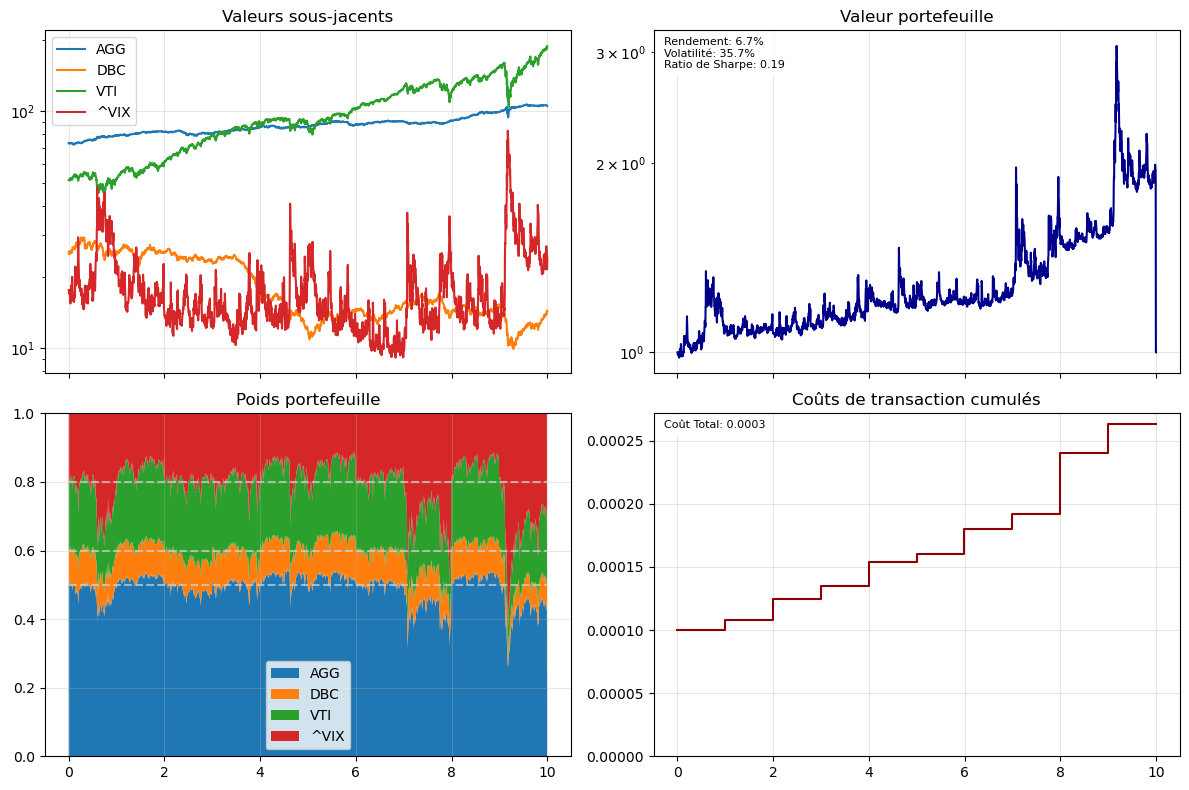

In [56]:
t, portfolio_value, weights_actual, weights_target, index_rebalancing, rebalancing_cost = simulate_portfolio(spot, years, allocation2, C=0.0001, rebalancing_freq='yearly')

fig, axes = plot_portfolio_analysis(
    t=t,
    spot=spot,
    portfolio_value=portfolio_value,
    weights_actual=weights_actual,
    weights_target=weights_target,
    index_rebalancing=index_rebalancing,
    rebalancing_cost=rebalancing_cost
)
plt.show()

Allocation3 = [0.1, 0.5, 0.2, 0.2], C=1bps, Pas de volatility scaling (rebalancement annuel)

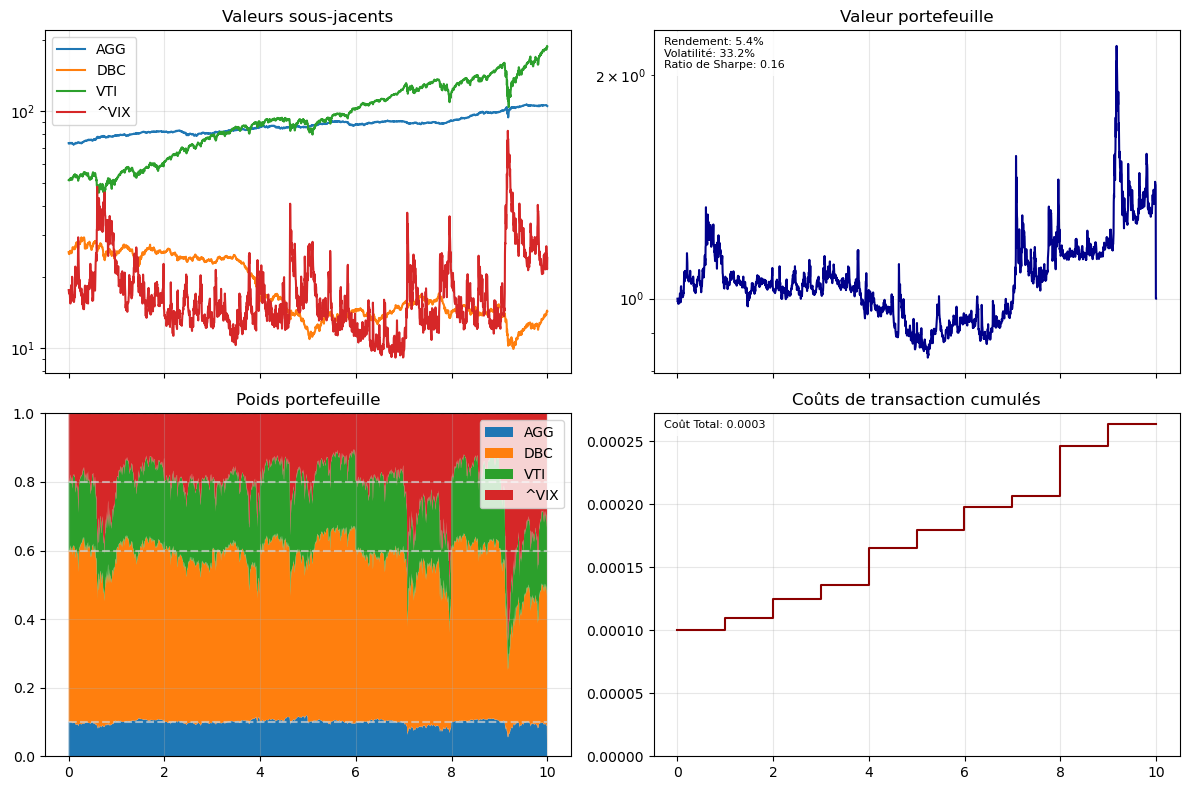

In [57]:
t, portfolio_value, weights_actual, weights_target, index_rebalancing, rebalancing_cost = simulate_portfolio(spot, years, allocation3, C=0.0001, rebalancing_freq='yearly')

fig, axes = plot_portfolio_analysis(
    t=t,
    spot=spot,
    portfolio_value=portfolio_value,
    weights_actual=weights_actual,
    weights_target=weights_target,
    index_rebalancing=index_rebalancing,
    rebalancing_cost=rebalancing_cost
)
plt.show()

Allocation4 = [0.4, 0.4, 0.1, 0.1], C=1bps, Pas de volatility scaling (rebalancement annuel)

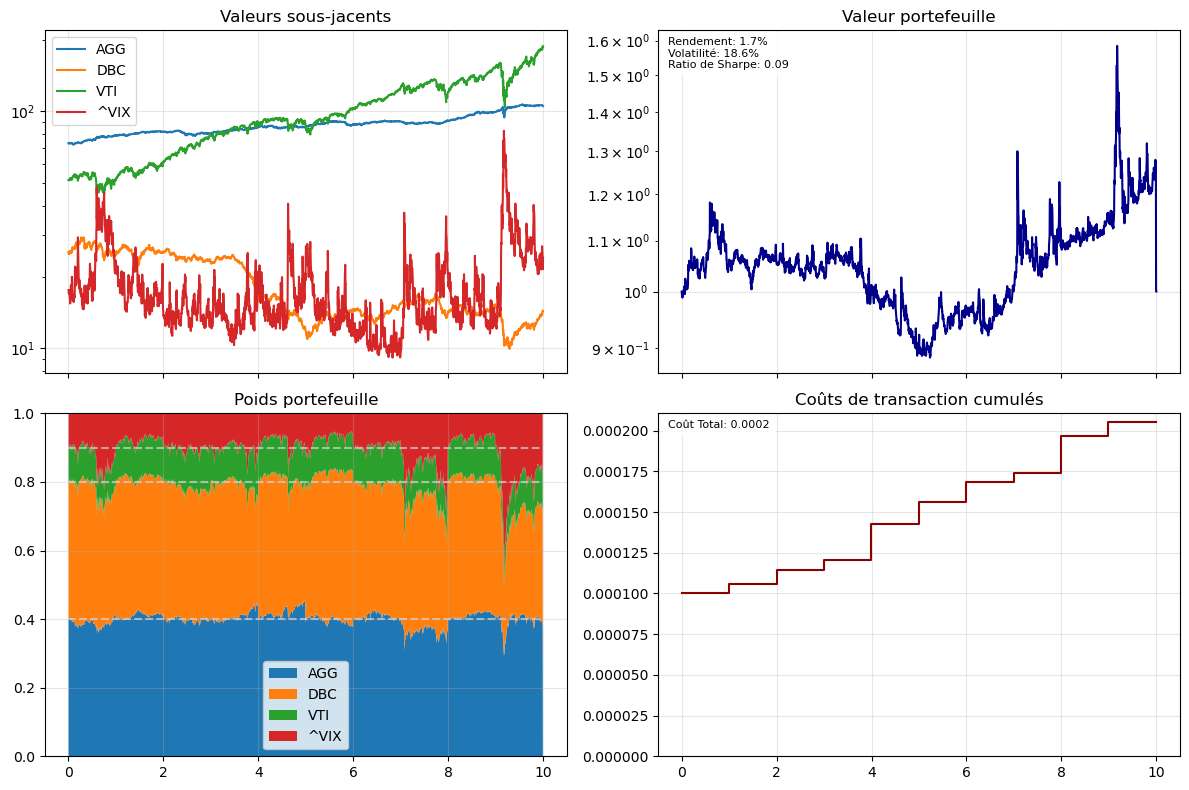

In [58]:
t, portfolio_value, weights_actual, weights_target, index_rebalancing, rebalancing_cost = simulate_portfolio(spot, years, allocation4, C=0.0001, rebalancing_freq='yearly')

fig, axes = plot_portfolio_analysis(
    t=t,
    spot=spot,
    portfolio_value=portfolio_value,
    weights_actual=weights_actual,
    weights_target=weights_target,
    index_rebalancing=index_rebalancing,
    rebalancing_cost=rebalancing_cost
)
plt.show()

Pour les 4 allocations, l'espérance de rendement est systématiquement inférieure à celle de l'article. Je soupçonne que cela doit etre due à une erreur dans son calcul ? 


## Prise en compte de la volatilité scaling (eq 7)

In [59]:
# Parameters
target_volatility = 0.1
w = 50  # window of 50 days
N = len(spot)


In [60]:
def compute_rolling_volatility(value, window):
    returns = np.diff(np.log(value), n=1, axis=0)
    volatility = np.lib.stride_tricks.sliding_window_view(
        returns, window_shape=window, axis=0
    ).std(axis=-1)
    return volatility * np.sqrt(252)


def simulate_portfolio_vol_scaling(spot, years, allocation, C=0.0001, target_volatility = 0.1, window = 50, rebalancing_freq='yearly'):
   
    N = len(spot)
    d = len(allocation)
    t = np.linspace(start=0, stop=years, num=N)
    log_returns = np.log(spot[1:] / spot[:-1])  # Rendements logarithmiques
    sigma = log_returns.std(axis=0) * np.sqrt(252)  

    # Définir les indices de rebalancement selon la fréquence
    if rebalancing_freq == 'yearly':
        index_rebalancing = np.arange(0, N, 21*12)
    elif rebalancing_freq == 'monthly':
        index_rebalancing = np.arange(0, N, 21)
    else:  # daily
        index_rebalancing = np.arange(0, N, 1)


    # Contrôle de la vol
    portfolio_value_controlled   = np.ones(shape=N)
    rebalancing_cost_controlled  = np.zeros(shape=N)
    weights_target_controlled = np.tile(allocation, (N, 1))
    weights_actual_controlled    = np.zeros(shape=(N, d+1))
    
    # Simulation
   
    for s in range(N-1):
        if s < w:
            realized_volatility = target_volatility
        else:
            realized_volatility = compute_rolling_volatility(value=spot[s-w: s+1], window=w)
        rescaling_volatility = target_volatility / realized_volatility

        weights_target_controlled[s]    = weights_target_controlled[s] * rescaling_volatility
        weights_target_controlled[s]   /= np.maximum(1, weights_target_controlled[s].sum())

        rebalancing_cost_controlled[s]  = portfolio_value_controlled[s] * np.abs(weights_target_controlled[s] - weights_actual_controlled[s, :-1]).sum() * C

        weights_actual_controlled[s+1, :-1]  = (spot[s+1] / spot[s]) * weights_target_controlled[s]
        weights_actual_controlled[s+1, :-1] /= np.maximum(1, weights_actual_controlled[s+1].sum())
        weights_actual_controlled[s+1, -1]   = 1 - weights_actual_controlled[s+1, :-1].sum()    # cash

        portfolio_returns_controlled    = (spot[s+1] / spot[s] - 1) @ weights_target_controlled[s]
        portfolio_value_controlled[s+1] = (portfolio_value_controlled[s] - rebalancing_cost_controlled[s]) * (1 + portfolio_returns_controlled)

    volatility = compute_rolling_volatility(value=spot, window=w)
    portfolio_volatility = compute_rolling_volatility(value=portfolio_value, window=w)
    portfolio_volatility_controlled = compute_rolling_volatility(value=portfolio_value_controlled, window=w)
        
    
    return t, sigma, volatility, portfolio_value_controlled, portfolio_volatility,  portfolio_volatility_controlled, weights_actual_controlled, weights_target, index_rebalancing


In [67]:
def plot_portfolio_vol(t, sigma, volatility, portfolio_value, portfolio_value_controlled,
                          portfolio_volatility, portfolio_volatility_controlled,
                          weights_actual_controlled, index_rebalancing,
                          target_volatility, window=50, asset_labels=None):

    if asset_labels is None:
        asset_labels = ['AGG', 'DBC', 'VTI', '^VIX']
    
    # Création de la figure avec 4 subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(12, 8))
    
    # 1. Volatilités sous-jacents
    ax = axes[0, 0]
    ax.set_title("Volatilités sous-jacents")
    ax.plot(t[window:], np.tile(sigma, reps=(len(t)-window, 1)), color="lightgrey")
    for i, label in enumerate(asset_labels):
        ax.plot(t[window:], volatility[:, i], label=label)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Valeurs portefeuilles
    ax = axes[0, 1]
    ax.set_title("Valeurs portefeuilles")
    ax.plot(t, portfolio_value, label="Portfolio Value")
    ax.plot(t, portfolio_value_controlled, label="Controlled Portfolio Value")
    ax.set_yscale("log")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Calcul et affichage des métriques de performance
    returns = pd.Series(portfolio_value_controlled).pct_change().dropna()
    volatility = returns.std() * np.sqrt(252)
    sharpe = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
    
    # Ajout des métriques sur le graphique
    ax.text(0.02, 0.98, 
            f'Rendement: {returns.mean() * 252*100:.1f}%\n'
            f'Volatilité: {volatility*100:.1f}%\n'
            f'Ratio de Sharpe: {sharpe:.2f}',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
            verticalalignment='top',
            fontsize=8)

    # 3. Poids portefeuille
    ax = axes[1, 0]
    ax.set_title("Poids portefeuille")
    labels = asset_labels + ['cash']
    ax.stackplot(t, *weights_actual_controlled.T, labels=labels)
    weights_theory  = weights_target
    weights_theory /= weights_theory.sum(axis=1, keepdims=True)

    ax.plot(t[index_rebalancing], weights_theory.cumsum(axis=1), 
            color="lightgrey", linestyle='--', alpha=0.5)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Volatilités portefeuille
    ax = axes[1, 1]
    ax.set_title("Volatilités portefeuille (mobile {} jours)".format(window))
    ax.plot(t[window:], portfolio_volatility, label="Portfolio volatility")
    ax.plot(t[window:], portfolio_volatility_controlled, 
            label="Controlled Portfolio Volatility")
    ax.axhline(y=target_volatility, color="lightgrey", 
               linestyle='--', label="Target Volatility")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Ajustement du layout
    fig.tight_layout()
    
    return fig



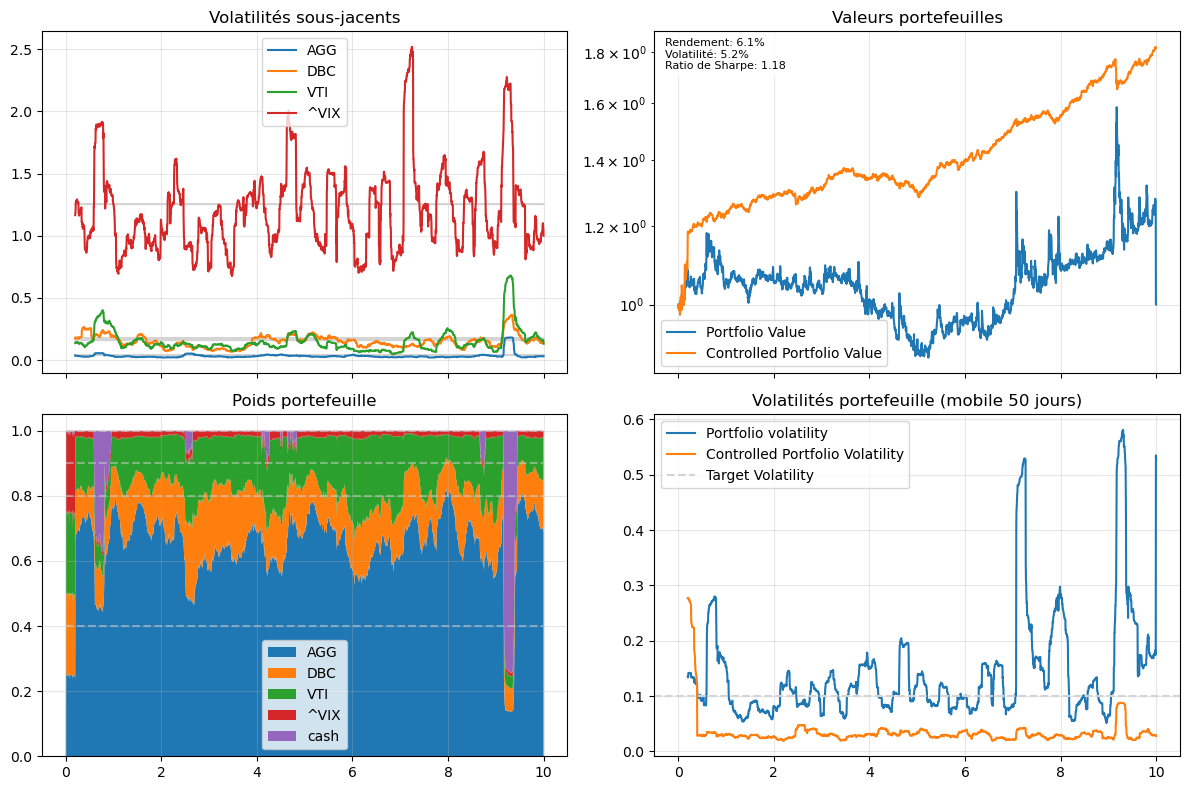

In [70]:
t, sigma, volatility, portfolio_value_controlled, portfolio_volatility,  portfolio_volatility_controlled, weights_actual_controlled, weights_target, index_rebalancing = simulate_portfolio_vol_scaling(spot, years, allocation1, C=0.0001, target_volatility = 0.1, window = 50, rebalancing_freq='yearly')

fig = plot_portfolio_vol(
    t=t,
    sigma=sigma,
    volatility=volatility,
    portfolio_value=portfolio_value,
    portfolio_value_controlled=portfolio_value_controlled,
    portfolio_volatility=portfolio_volatility,
    portfolio_volatility_controlled=portfolio_volatility_controlled,
    weights_actual_controlled=weights_actual_controlled,
    index_rebalancing=index_rebalancing,
    target_volatility=target_volatility,
    window=50,
    asset_labels=['AGG', 'DBC', 'VTI', '^VIX']
)
plt.show()

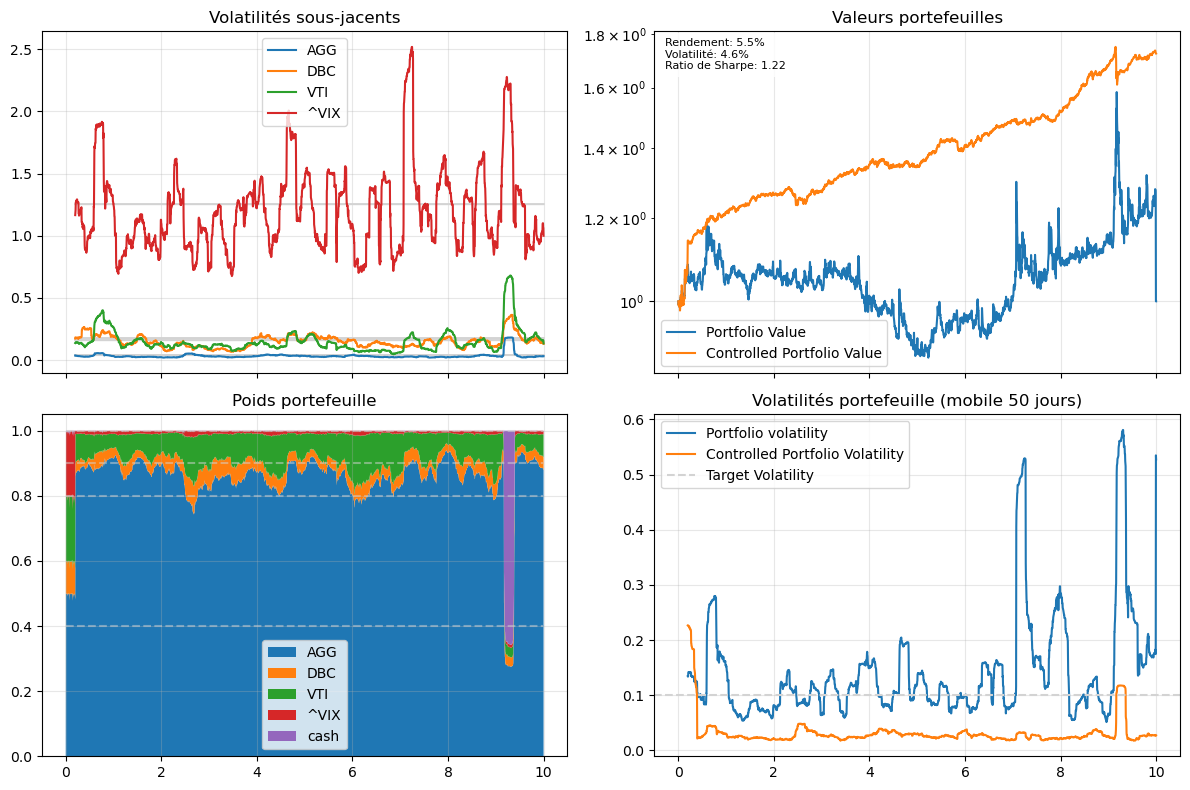

In [72]:
t, sigma, volatility, portfolio_value_controlled, portfolio_volatility,  portfolio_volatility_controlled, weights_actual_controlled, weights_target, index_rebalancing = simulate_portfolio_vol_scaling(spot, years, allocation2, C=0.0001, target_volatility = 0.1, window = 50, rebalancing_freq='yearly')

fig = plot_portfolio_vol(
    t=t,
    sigma=sigma,
    volatility=volatility,
    portfolio_value=portfolio_value,
    portfolio_value_controlled=portfolio_value_controlled,
    portfolio_volatility=portfolio_volatility,
    portfolio_volatility_controlled=portfolio_volatility_controlled,
    weights_actual_controlled=weights_actual_controlled,
    index_rebalancing=index_rebalancing,
    target_volatility=target_volatility,
    window=50,
    asset_labels=['AGG', 'DBC', 'VTI', '^VIX']
)
plt.show()

Une question plus générale : pourquoi introduire le cash lorsqu'on prend en compte la volatilité scaling ? 

Ici, aussi le calcul des métriques donnent des résultats différents de ceux de l'article, d'ou peut provenir l'erreur ?